In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sunpy.time import parse_time
import sunpy.map
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from astropy import units as u
import datetime
import subprocess
import pylab

In [41]:
# read in the data as a pandas DataFrame
all_data = pd.read_csv('concat_1996-2020.csv')
all_data = all_data[all_data['event_starttime'] >'2008-01-01']
# get the time as datetime objects
tt = list(pd.to_datetime(all_data['event_starttime']))
# get the time in seconds from initial time (for plotting)
times = [(t - tt[0]).total_seconds() for t in tt]
# make these columns of DataFrame
all_data['times'] = times
all_data['tt'] = tt

# we want to make a list of all the dates from 2010-2020 for
# plotting, this will allow us to pull out the active regions 
# for each day (or not if none on a certain day) for plotting.
tstart = parse_time(all_data['event_starttime'].min()).datetime
tfinal = parse_time(all_data['event_endtime'].max()).datetime
time_over = [tstart.strftime('%Y-%m-%dT%H:%M:%S')]
t0 = tstart
while t0 < tfinal:
    t0 = t0 + datetime.timedelta(days=1)
    time_over.append(t0.strftime('%Y-%m-%dT%H:%M:%S'))

# this is a rough conversion for area of active region at disk
# center in km to area in arcsec (as observed from Earth). If you 
# want to be more precise you would calculate for each day, but
# its grand for this purpose.
all_data['area_arcsec'] = all_data['area_atdiskcenter']/(725**2)

## Read in SilSO data

In [42]:
def read_ssn():
    ssn = pd.read_csv("../SN_m_tot_V2.0.csv", names=['year', 'month', 'decimal_date', \
                                                  'ssn', 'ssn_dev', 'number_obs', 'indicator'], 
             delimiter=';')
    years = ssn['year'].values; months = ssn['month']
    tt = [datetime.datetime(ssn['year'][i], ssn['month'][i], 1) for i in range(len(ssn))]


    ssn['times'] = tt

    return ssn.set_index('times')
ssn = read_ssn()

## Plotting routines

In [45]:
def plot_as_datapoints(i, savedir='./plots/'):
    """
    This function plots the Sun with the daily active regions, the butterfly diagram, 
    and histogram for the data up to the date time_over[i].

    The plot will be saved in ./plots with the name test_i.png. 
    To make the movie, the plots needs to be sequentially ordered. 

    Parameters
    ----------
    i : ~int
        the index of the `time_over` list for which to plot. 

    """


    # find the active region data for the day from the dataframe
    data_for_day = all_data[all_data['event_starttime'].isin([time_over[i]])]

    # get the daya for the past 10 days previous to timestep i. This is to plot the previous
    # active regions with a colormap to highlight the active region evolution.
    if i < 10:
        data_for_days = all_data[all_data['event_starttime'].isin(time_over[0:i])]
    else:
        data_for_days = all_data[all_data['event_starttime'].isin(time_over[i-10:i])]

    # get the data for the past 100 days from i for faint active region plot
    if i < 100:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[0:i])]
    else:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[i-100:i])]
   
    # all previous data up to date (i) for butterfly diagram.
    data_all_past = all_data[all_data['event_starttime'].isin(time_over[0:i])]

    #########################################
    # where plot happens

    # define axes
    fig = plt.figure(figsize=(7, 8))
    ax1 = pylab.axes([0.12, 0.02, 0.62, 0.62])
    ax2 = pylab.axes([0.75, 0.0595, 0.22, 0.542], sharey=ax1)
    ax3 = pylab.axes([0.12, 0.66, 0.62, 0.33])

    # plotting on disk!

    # for all past
    if len(data_for_past)>0:

        ax1.scatter(data_for_past['hpc_x'], data_for_past['hpc_y'], c=data_for_past['times'], 
                    s=2*np.sqrt(data_for_past['area_arcsec']),  alpha=0.1, cmap='Reds',
                    edgecolor='k', lw=0.4)

    # for day
    if len(data_for_day)>0:
        ax1.scatter(data_for_day['hpc_x'], data_for_day['hpc_y'], 
                    s=2*np.sqrt(data_for_day['area_arcsec']),
                    color='k')

    # for days previous
    if len(data_for_days)>0:
        ax1.scatter(data_for_days['hpc_x'], data_for_days['hpc_y'], c=data_for_days['times'], 
                    s=2*np.sqrt(data_for_days['area_arcsec']), cmap='Reds',
                    edgecolor='k', lw=0.4)        


    # approximate radius of Sun in arcsecs
    circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
    ax1.add_artist(circle1)
    ax1.set_aspect('equal', adjustable='box') # make square
    ax1.set_xlim(-1101, 1101) 
    ax1.set_ylim(-1101, 1101)
    ax1.set_xlabel('Helioprojective Longitude (arcsec)')
    ax1.set_ylabel('Helioprojective Latitude (arcsec)')
    ax1.tick_params(which='both', direction='in')


    # plotting histogram to right of Sun
    na, bins, patches = ax2.hist(data_all_past['hpc_y'], bins=100, orientation='horizontal', color='darkred')
    ax2.set_ylim(-1101, 1101)
    ax2.tick_params(labelleft=False, which='both', direction='in')
    ax2.set_xlabel('No. active regions')
    ax2.set_xlim(0, 300)

    # plotting butterfly diagram
    ax3.scatter(data_all_past['tt'], data_all_past['hgc_y'], c=data_all_past['times'], alpha=0.3, 
              s=np.sqrt(data_all_past['area_arcsec']), 
              edgecolor='k', lw=0.4, cmap='Reds')
    ax3.axvline(parse_time(time_over[i]).datetime, color='k', ls='dashed')
    ax3.set_xlabel('Time (UT)')
    ax3.set_ylabel('Latitude (deg)')
    ax3.tick_params(which='both', direction='in')
    ax3.set_xlim(all_data['tt'].min(), all_data['tt'].max())
    ax3.set_ylim(-45, 45)
    

    # save the plot
#     plt.savefig(savedir + 'test_{:04d}.png'.format(i), dpi=200)
#     plt.close()


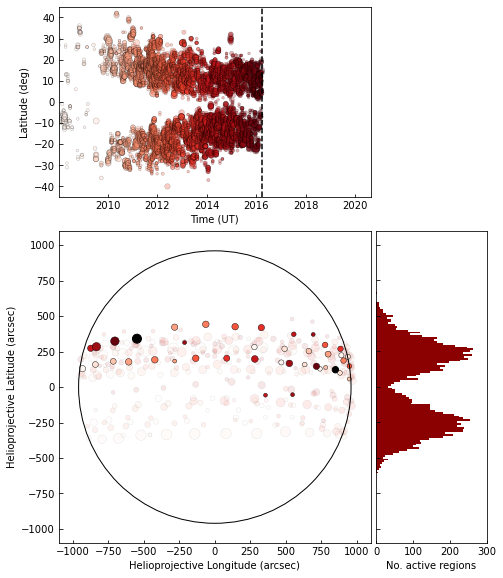

In [46]:
plot_as_datapoints(3000)

In [64]:
def plot_as_datapoints2(i, savedir='./plots/', cmap='Reds'):
    """
    This function plots the Sun with the daily active regions, the butterfly diagram, 
    and histogram for the data up to the date time_over[i].

    The plot will be saved in ./plots with the name test_i.png. 
    To make the movie, the plots needs to be sequentially ordered. 

    Parameters
    ----------
    i : ~int
        the index of the `time_over` list for which to plot. 

    """

    plt.style.use('dark_background')
    # find the active region data for the day from the dataframe
    data_for_day = all_data[all_data['event_starttime'].isin([time_over[i]])]

    # get the daya for the past 10 days previous to timestep i. This is to plot the previous
    # active regions with a colormap to highlight the active region evolution.
    if i < 10:
        data_for_days = all_data[all_data['event_starttime'].isin(time_over[0:i])]
    else:
        data_for_days = all_data[all_data['event_starttime'].isin(time_over[i-10:i])]

    # get the data for the past 100 days from i for faint active region plot
    if i < 100:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[0:i])]
    else:
        data_for_past = all_data[all_data['event_starttime'].isin(time_over[i-100:i])]
   
    # all previous data up to date (i) for butterfly diagram.
    data_all_past = all_data[all_data['event_starttime'].isin(time_over[0:i])]

    #########################################
    # where plot happens

    # define axes
    fig = plt.figure(figsize=(7, 8))
    ax1 = pylab.axes([0.12, 0.02, 0.62, 0.62])
    ax2 = pylab.axes([0.75, 0.0595, 0.22, 0.542], sharey=ax1)
    ax3 = pylab.axes([0.12, 0.66, 0.62, 0.33])

    # plotting on disk!
    # approximate radius of Sun in arcsecs
    circle1 = plt.Circle((0, 0), 960, color='orange', fill=True, zorder=0)
    ax1.add_artist(circle1)
    ax1.set_aspect('equal', adjustable='box') # make square
    ax1.set_xlim(-1101, 1101) 
    ax1.set_ylim(-1101, 1101)
    ax1.set_xlabel('Helioprojective Longitude (arcsec)')
    ax1.set_ylabel('Helioprojective Latitude (arcsec)')
    ax1.tick_params(which='both', direction='in')
    # for all past
    if len(data_for_past)>0:

        ax1.scatter(data_for_past['hpc_x'], data_for_past['hpc_y'], c=data_for_past['times'], 
                    s=2*np.sqrt(data_for_past['area_arcsec']),  alpha=0.1, cmap=cmap,
                    edgecolor='k', lw=0.4)

    
    # for day
    if len(data_for_day)>0:
        ax1.scatter(data_for_day['hpc_x'], data_for_day['hpc_y'], 
                    s=2*np.sqrt(data_for_day['area_arcsec']),
                    color='k')

    # for days previous
    if len(data_for_days)>0:
        ax1.scatter(data_for_days['hpc_x'], data_for_days['hpc_y'], c=data_for_days['times'], 
                    s=2*np.sqrt(data_for_days['area_arcsec']), cmap=cmap,
                    edgecolor='k', lw=0.4)        





    # plotting histogram to right of Sun
    na, bins, patches = ax2.hist(data_all_past['hpc_y'], bins=100, orientation='horizontal', color='darkred')
    ax2.set_ylim(-1101, 1101)
    ax2.tick_params(labelleft=False, which='both', direction='in')
    ax2.set_xlabel('No. active regions')
    ax2.set_xlim(0, 300)

    # plotting butterfly diagram
    ax3.scatter(data_all_past['tt'], data_all_past['hgc_y'], c=data_all_past['times'], alpha=0.3, 
              s=np.sqrt(data_all_past['area_arcsec']), 
              edgecolor='k', lw=0.4, cmap=cmap)
    ax3.axvline(parse_time(time_over[i]).datetime, color='k', ls='dashed')
    ax3.set_xlabel('Time (UT)')
    ax3.set_ylabel('Latitude (deg)')
    ax3.tick_params(which='both', direction='in')
    ax3.set_xlim(all_data['tt'].min(), all_data['tt'].max())
    ax3.set_ylim(-45, 45)
    

    # save the plot
#     plt.savefig(savedir + 'test_{:04d}.png'.format(i), dpi=200)
#     plt.close()


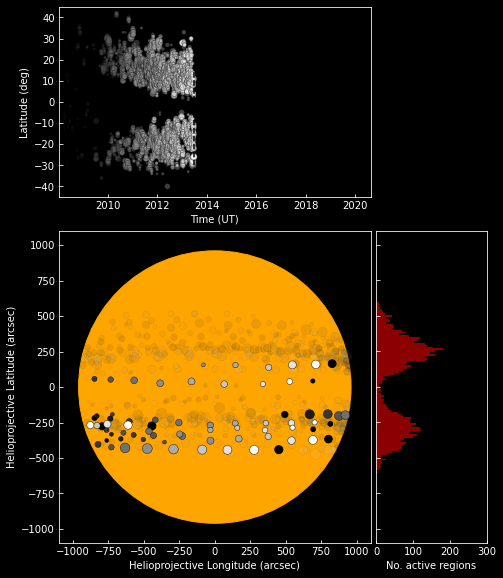

In [66]:
plot_as_datapoints2(2000, cmap='binary_r')